# Hamilton Character Analysis Project
A wip little NLP project looking at the speech of each character in Hamilton :3 

## 1. Extracting character lines

In [3]:
import re

content = ""
with open("act1.txt", encoding="utf-8") as file:
    content += file.read()
with open("act2.txt", encoding="utf-8") as file:
    content += file.read()
    content = re.sub(r'\n\d+\s*\n', '\n', content)
with open("raw.txt", "w", encoding="utf-8") as file:
    file.write(content)

In [186]:
# ltk.download('wordnet')
# nltk.download('omw-1.4')  # For lemmatization
# nltk.download('punkt_tab') # This downloads the punkt tokenizer model

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\grace\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\grace\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\grace\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [38]:
import nltk

from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

def get_lines(character):
    """
    extracts all lines(string) from character(string).
    """
    content = ""
    with open("raw.txt", encoding="utf-8") as file:
        content = file.read()
    
    # ([A-Z]+(?:\s+[A-Z]+)* \n)
    # for extracting all singer names (bug with "FULL COMPANY (EXCEPT HAMILTON) ")
    content = re.sub(r"\d+\..+\n", "", content)  # stripping song names
    regex = character.upper() + r".*([\s\S]+?)(?=\b[A-Z]{2,}\b)"
    lines = re.findall(regex, content)
    result = []
    for index, line in enumerate(lines):
        line = line.replace("\\n", " ").replace("/", "").strip()
        line = line.replace('\n', '').strip()
        line = re.sub(r"[’']", "", line)
        result.append(line)
    all_lines = " ".join(result)
    return all_lines
    print(get_lines("eliza")[:500])

## Preprocess text

* tokenize
* removing stopwords

In [71]:
from nltk.corpus import stopwords
# nltk.download('stopwords')
# nltk.download('punkt')

def tokenize_lines(line):
    # tokenize and strip punctuation
    tokens = word_tokenize(line)
    tokens = [word.lower() for word in tokens if word.isalnum()]
    return tokens
    
def remove_stopwords(tokens):
    stop_words = set(stopwords.words('english'))
    important_words = {'not'}
    
    custom_stopwords = stop_words - important_words
    result = []
    removed = set()
    for token in tokens:
        if token in custom_stopwords:
            removed.add(token)
        else:
            result.append(token)
    return (result, removed)
    # print(f"removed: {removed}")
    # print(f"final result: {result}")
    
all_lines = ""
for char in characters:
    all_lines = all_lines + get_lines(char)
    
tokens = tokenize_lines(all_lines)
# print(f"tokenize_lines words: {tokens[:200]} \n")

(filtered, filtered_out) = remove_stopwords(tokens)
print(f"filtered more: {filtered[:200]} \n")
print(f"filtered_out : {filtered_out} \n")


filtered more: ['hear', 'ye', 'hear', 'ye', 'name', 'samuel', 'seabury', 'present', 'free', 'thoughts', 'proceedings', 'continental', 'congress', 'heed', 'not', 'rabble', 'scream', 'revolution', 'not', 'interests', 'heart', 'chaos', 'bloodshed', 'not', 'solution', 'dont', 'let', 'lead', 'astray', 'congress', 'not', 'speak', 'theyre', 'playing', 'dangerous', 'game', 'pray', 'king', 'shows', 'mercy', 'shame', 'heed', 'not', 'rabble', 'scream', 'revolution', 'not', 'interests', 'heart', 'chaos', 'bloodshed', 'not', 'solution', 'dont', 'let', 'lead', 'astray', 'congress', 'not', 'speak', 'theyre', 'playing', 'dangerous', 'game', 'pray', 'king', 'shows', 'mercy', 'shame', 'shame', 'not', 'cousin', 'cousin', 'committed', 'suicide', 'left', 'nothin', 'ruined', 'pride', 'something', 'new', 'inside', 'voice', 'saying', 'got', 'ta', 'fend', 'started', 'retreatin', 'readin', 'every', 'treatise', 'shelf', 'trusted', 'outgunned', 'outmanned', 'outnumbered', 'outplanned', 'got', 'ta', 'make', 'stand

## Saving the character lines in the CSV file

In [91]:
import pandas as pd

characters = ["SEABURY", "WASHINGTON", "MADISON", "LAURENS", "ELIZA", "MARIA", 
              "HAMILTON", "LAFAYETTE", "MULLIGAN", "JEFFERSON", "PHILIP", "BURR",
              "ANGELICA", "PEGGY"]

character_lines = []
for c in characters:
    character_map = {}
    character_map["character"] = c.lower()
    
    lines = get_lines(c)
    character_map["lines"] = get_lines(c)
    
    tokens = tokenize_lines(get_lines(c))

    # print("\n\n" + c + "\n" + str(tokens))
    character_map["tokens"] = " ".join(tokens)

    tokens, _ = remove_stopwords(tokens)
    # print("\n\n" + c + "\n" + str(tokens))
    character_map["filtered_tokens"] = " ".join(tokens)
    
    character_lines.append(character_map)
    
df = pd.DataFrame(character_lines)
df.to_csv("character_lines.csv", index=False)  # index=False skips the row numbers

# TF-IDF vectors

In [98]:
import pandas as pd

df = pd.read_csv("character_lines.csv")

from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(df["filtered_tokens"])

from sklearn.metrics.pairwise import cosine_similarity

similarity_matrix = cosine_similarity(X)

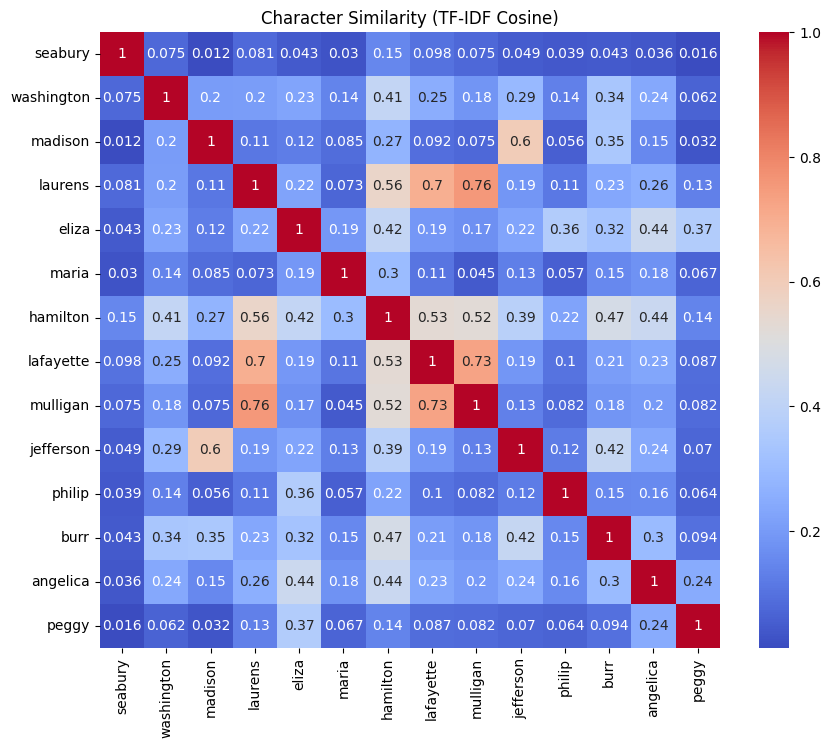

In [103]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
sns.heatmap(similarity_matrix,
            xticklabels=df["character"],
            yticklabels=df["character"],
            cmap="coolwarm", annot=True)
plt.title("Character Similarity (TF-IDF Cosine)")
plt.show()

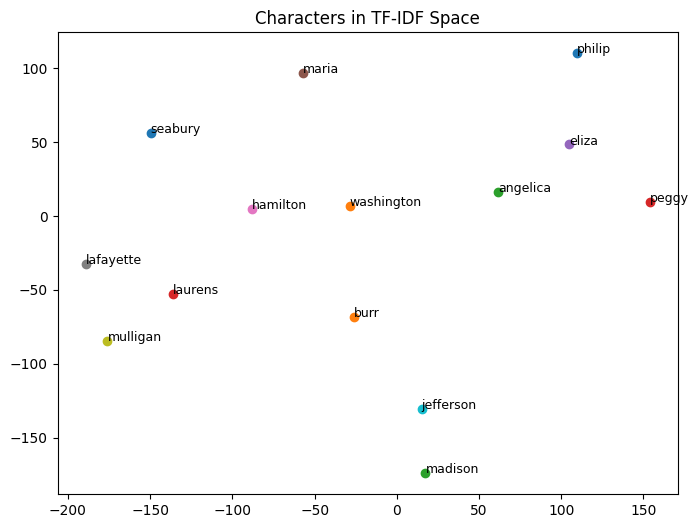

In [104]:
from sklearn.manifold import TSNE

X_tsne = TSNE(n_components=2, perplexity=5, random_state=0).fit_transform(X.toarray())

plt.figure(figsize=(8, 6))
for i, name in enumerate(df["character"]):
    x, y = X_tsne[i]
    plt.scatter(x, y)
    plt.text(x + 0.01, y + 0.01, name, fontsize=9)
plt.title("Characters in TF-IDF Space")
plt.show()

# Topic Modeling with LDA
* Use `LatentDirichletAllocation` to extract topics from character lyrics.
* Print top words per topic and assign topic distributions to characters.
* Compare which themes dominate each character’s dialogue.

In [169]:
# df = pd.read_csv("character_lines.csv")
documents = df["filtered_tokens"].fillna("").tolist()

# Vectorize using CountVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

custom_stopwords = set([
    "im", "oh", "hey", "na", "like", "gon", "dont", "youre", "sir", "look"
    "say", "theyre", "whoa", "dont", "didnt", "hes", "therell", "yo"
]) | ENGLISH_STOP_WORDS

vectorizer = CountVectorizer(ngram_range=(1, 1), stop_words=list(custom_stopwords))
doc_term_matrix = vectorizer.fit_transform(documents)

from sklearn.decomposition import LatentDirichletAllocation

# Try with 5–10 topics, tune based on results
lda = LatentDirichletAllocation(n_components=3)
lda.fit(doc_term_matrix)

topics = {}
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print(f"\nTopic #{topic_idx + 1}:")
        top_words = " ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]])
        print(top_words)
        topics[topic_idx + 1] = top_words

display_topics(lda, vectorizer.get_feature_names_out(), 10)


Topic #1:
look know angelica stay time satisfied sister mind alive world

Topic #2:
know hamilton nice away burr say got time room shot

Topic #3:
shot away rise throwing time tonight raise glass lets freedom


## trying to find the best # of clusters

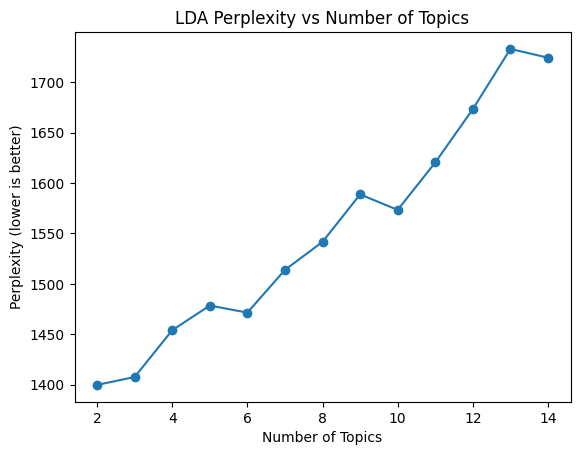

In [130]:
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import pairwise_distances
import numpy as np

vectorizer = CountVectorizer()
X = vectorizer.fit_transform(df["filtered_tokens"])

perplexities = []
for n in range(2, 15):
    lda = LatentDirichletAllocation(n_components=n, random_state=0)
    lda.fit(X)
    perplexities.append(lda.perplexity(X))

import matplotlib.pyplot as plt

plt.plot(range(2, 15), perplexities, marker='o')
plt.xlabel("Number of Topics")
plt.ylabel("Perplexity (lower is better)")
plt.title("LDA Perplexity vs Number of Topics")
plt.show()

## Identify how each character corrrelates with which topics

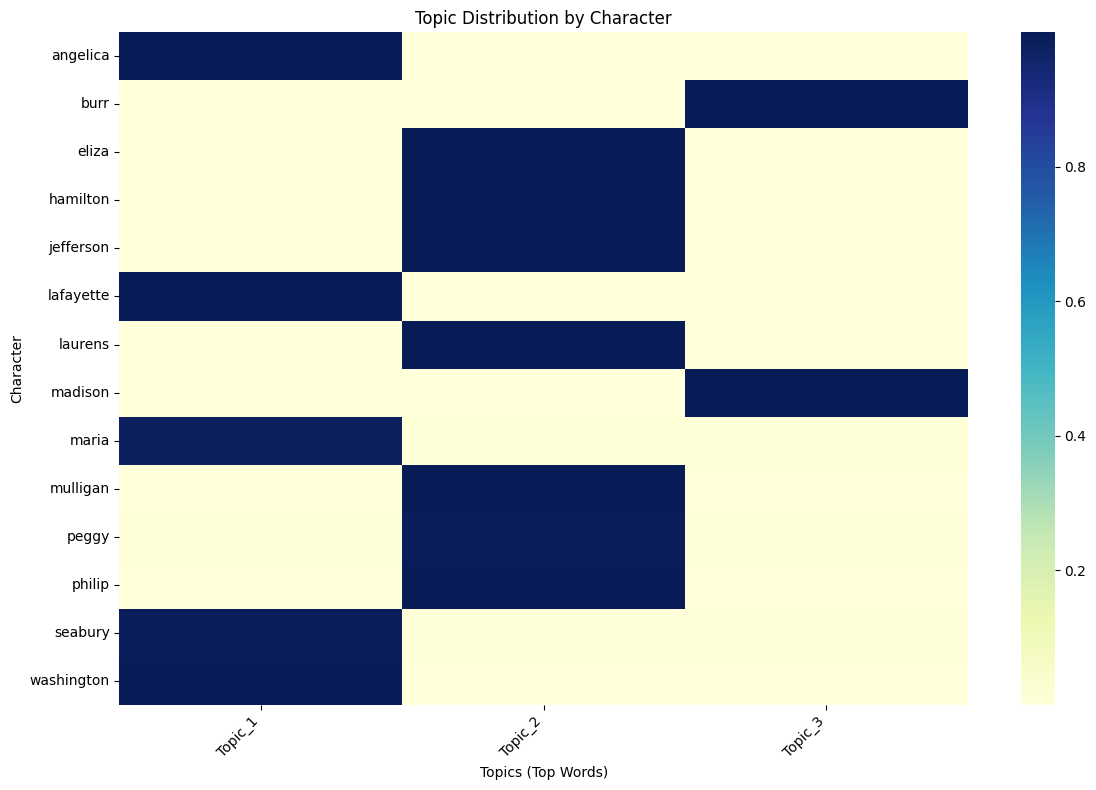

In [171]:
# Extract topic columns (assuming these are named 'Topic_1', 'Topic_2', etc.)
topic_cols = [col for col in df.columns if col.startswith("Topic_")]
heatmap_data = df.groupby("character")[topic_cols].mean()

# Create topic label names using your mapping
new_col_names = [topics[int(col.split("_")[1])] for col in topic_cols]

# Plot heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data, annot=False, cmap="YlGnBu")
plt.xlabel("Topics (Top Words)")
plt.ylabel("Character")
plt.title("Topic Distribution by Character")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

# 🎭 Hamilton Lyrics Analysis Project Roadmap

This project explores character identity and style in *Hamilton* using NLP and machine learning. There are two main parts:

- **Part 1:** Compare and analyze character lyrics (semantic, stylistic, emotional).
- **Part 2:** Build an ML model to predict who said a given line.

---

## ✅ Part 1: Character Lyrics Analysis

### 1. Extract and Clean Character Lines
- [ ] Parse the script using regex to assign lines to characters.
- [ ] Normalize contractions (e.g. “I’m” → “I am”) and remove stage directions.
- [ ] Filter down to major characters (e.g. HAMILTON, BURR, ANGELICA, ELIZA, etc.)

> **Why it's interesting:** Creates a solid foundation for every analysis step. Also fun to debug regex against a real-world script format!

---

### 2. Bag-of-Words + TF-IDF Vectors
- [ ] Use `TfidfVectorizer` to convert character documents into vectors.
- [ ] Compute cosine similarity between characters.
- [ ] Visualize as a similarity matrix or heatmap.

> **Why it's interesting:** Shows how “close” characters are based on word usage — maybe Burr and Jefferson cluster together?

---

### 3. Topic Modeling with LDA
- [ ] Use `LatentDirichletAllocation` to extract topics from character lyrics.
- [ ] Print top words per topic and assign topic distributions to characters.
- [ ] Compare which themes dominate each character’s dialogue.

> **Why it's interesting:** Surfaces hidden thematic structures — e.g., Hamilton might have “legacy/politics” topics vs. Eliza’s “family/love.”

---

### 4. Word Embedding Averages
- [ ] Train Word2Vec or use pretrained GloVe vectors.
- [ ] Average each character’s line embeddings.
- [ ] Plot with PCA or t-SNE to visualize how semantically distinct they are.

> **Why it's interesting:** Goes beyond word frequency — characters who *mean* similar things may show up close even if they use different vocab.

---

### 5. Emotion & Sentiment Analysis
- [ ] Use NRC Emotion Lexicon or VADER to score lines for emotion categories.
- [ ] Aggregate per character (e.g., Hamilton has more anger, Eliza more trust?)
- [ ] Optionally visualize emotions over time or by act/song.

> **Why it's interesting:** You can actually map Hamilton’s emotional arc — and compare it to Burr’s or Angelica’s.

---

### 6. Syntactic & Stylistic Analysis
- [ ] Use `spaCy` to extract POS tag distributions per character.
- [ ] Analyze sentence length, use of exclamations/questions/imperatives.
- [ ] Compare rhetoric: does Hamilton use more first-person pronouns? Does Burr ask more questions?

> **Why it's interesting:** Stylometry insights — helps detect *how* characters speak, not just what they say.

---

## 🤖 Part 2: Machine Learning Classifier (Who Said This Line?)

### 1. Create Dataset
- [ ] Convert your extracted data into line/label pairs: `(line, speaker)`
- [ ] Remove characters with very few lines or group them as "OTHER"
- [ ] Split into training/test sets

> **Why it's interesting:** Prepping your own dataset is the first step in any applied ML project — and you’ll spot quirks in the dialogue.

---

### 2. Baseline Classifier with TF-IDF
- [ ] Use `TfidfVectorizer` + `LogisticRegression`
- [ ] Train model to predict the speaker
- [ ] Evaluate accuracy and confusion matrix

> **Why it's interesting:** This shows how distinguishable character voices are just by word use — are Eliza’s lines harder to separate than Burr’s?

---

### 3. Try Other Classical Models
- [ ] Swap in `MultinomialNB`, `RandomForestClassifier`, `SVM`
- [ ] Compare performance

> **Why it's interesting:** See which models handle sparse, high-dimensional text best — useful ML comparison exercise.

---

### 4. Neural Model (LSTM or BiLSTM)
- [ ] Use `Tokenizer` + `pad_sequences` to prepare input
- [ ] Train an LSTM-based classifier using Keras or PyTorch
- [ ] Track training loss + accuracy

> **Why it's interesting:** Neural models can “learn” writing style and sentence structure — deeper representation of how characters speak.

---

### 5. Transformer-Based Model (e.g. BERT)
- [ ] Use HuggingFace `transformers` to fine-tune `bert-base-uncased`
- [ ] Frame it as a text classification task (line → character)
- [ ] Evaluate results and compare to earlier models

> **Why it's interesting:** You’re using state-of-the-art tools on a creative dataset — it's a strong portfolio piece.

---

### 6. Model Explainability
- [ ] Try `LIME` or `SHAP` to explain why the model predicted a certain character
- [ ] Visualize important words per prediction

> **Why it's interesting:** Makes the model feel less like a black box — great way to show what distinguishes characters linguistically.

---

### 7. (Optional) Interactive Demo
- [ ] Use `Streamlit` or `Gradio` to build a web interface
- [ ] User inputs a line, app predicts speaker + confidence + top keywords
- [ ] Add character stats or emotion radar plots

> **Why it's interesting:** Super fun way to present your work — and lets others play with your model.

---

## 🌟 Bonus / Stretch Ideas

- Compare Hamilton to *In The Heights* or *Les Mis* using the same pipeline
- Cluster lines into emotion or topic types *regardless* of speaker
- Detect sarcasm or rhetorical style
- Analyze rhyme/meter patterns with phoneme tools (`pronouncing`, `textstat`)
- Animate character emotion arcs across songs (timeline style)

---
